ORCL vs NVDA
Last PnL: 0.0
No trades


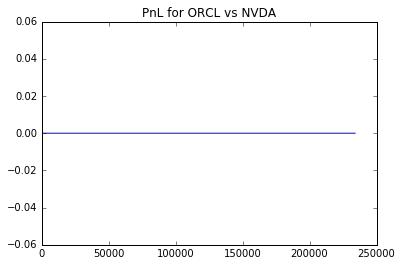

AAPL vs ORCL
Last PnL: 0.0
No trades


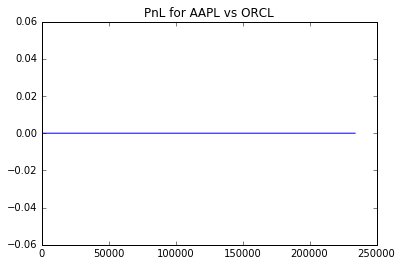

NVDA vs MSFT


In [ ]:
%%time
##The parameters are the same as in the other file, BUT threshold is removed, and instead we have to choose constans rho>0 (urgency parameter) and c
## and c>0 (a measure of the transaction costs). I have incorportared these two parameters to the class constructor and removed thresholds
## rho should be close to 0 (I have tried 0.01 and 0.001) and c as well (I have tried 0.01)

##The only differences with the other file are the block with all the new functions to compute the thresholds, and then in the execution part
#that instead of comparing s with fixed thresholds, we compare the last residual with a threshold that deppends on the OU parameters


import sys
from simulator import (
    Simulator, string_to_micro, micro_to_time,
    BUY, SELL, SHORT, EXCH_INET,
    BOOK_DEPTH1_PRICE, ORDER_EVENTS,
    )
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AR
from scipy import integrate 
from scipy import optimize


#### Functions to compute thresholds
def fplus(u,rho,epsilon,kappa, theta, sigma):
    #return u**(rho/kappa-1)*np.exp(-np.sqrt(2*kappa/sigma**2)*(theta-epsilon)*u-u**2/2)
    return sigma**(rho/kappa)*u**(rho/kappa-1)*np.exp(-np.sqrt(2*kappa)*(theta-epsilon)*u-(u*sigma)**2/2)


def fplus_der(u,rho,epsilon,kappa, theta, sigma):
    #return np.sqrt(2*kappa/sigma**2)*u**(rho/kappa)*np.exp(-np.sqrt(2*kappa/sigma**2)*(theta-epsilon)*u-u**2/2)
    return sigma**(rho/kappa)*np.sqrt(2*kappa)*u**(rho/kappa)*np.exp(-np.sqrt(2*kappa)*(theta-epsilon)*u-(u*sigma)**2/2)


def fminus(u,rho,epsilon,kappa, theta, sigma):
    #return u**(rho/kappa-1)*np.exp(np.sqrt(2*kappa/sigma**2)*(theta-epsilon)*u-u**2/2)
    return sigma**(rho/kappa)*u**(rho/kappa-1)*np.exp(np.sqrt(2*kappa)*(theta-epsilon)*u-(u*sigma)**2/2)


def fminus_der(u,rho,epsilon,kappa, theta, sigma):
    #return -np.sqrt(2*kappa/sigma**2)*u**(rho/kappa)*np.exp(np.sqrt(2*kappa/sigma**2)*(theta-epsilon)*u-u**2/2)
    return -sigma**(rho/kappa)*np.sqrt(2*kappa)*u**(rho/kappa)*np.exp(-np.sqrt(2*kappa)*(theta-epsilon)*u-(u*sigma)**2/2)


def Fplus(epsilon,rho, kappa, theta, sigma):
    integral,error = integrate.quad(fplus,0, np.inf, args = (rho,epsilon,kappa,theta,sigma,))
    return integral


def Fminus(epsilon,rho, kappa, theta, sigma):
    integral,error = integrate.quad(fminus,0, np.inf, args = (rho,epsilon,kappa,theta,sigma,))
    return integral


def Fplus_der(epsilon,rho, kappa, theta, sigma):
    integral,error = integrate.quad(fplus_der,0, np.inf, args = (rho,epsilon,kappa,theta,sigma,))
    return integral


def Fminus_der(epsilon,rho, kappa, theta, sigma):
    integral,error = integrate.quad(fminus_der,0, np.inf, args = (rho,epsilon,kappa,theta,sigma,))
    return integral


def long_close_function(epsilon,rho, kappa, theta, sigma,c):
    return (epsilon[0] - c)*Fplus_der(epsilon[0],rho, kappa, theta, sigma)-Fplus(epsilon[0],rho, kappa, theta, sigma)


def long_close(rho, kappa, theta, sigma, c): #epsilon^*+
    result = optimize.root(long_close_function,[1], args=(rho, kappa, theta, sigma, c,), method = 'lm')
    if result.success:
        return result.x[0]
    else:
        return (kappa*theta+c*rho)/(rho+kappa)

    
def short_close_function(epsilon,rho, kappa, theta, sigma,c):
    return (epsilon[0] + c)*Fminus_der(epsilon[0],rho, kappa, theta, sigma)-Fminus(epsilon[0],rho, kappa, theta, sigma)


def short_close(rho, kappa, theta, sigma, c): #epsilon^*-
    result = optimize.root(short_close_function,[-1], args=(rho, kappa, theta, sigma, c,), method = 'lm')
    if result.success:
        return result.x[0]
    else:
        return (kappa*theta-c*rho)/(rho+kappa)

    
def Hplus(epsilon,kappa,theta, sigma,rho,c):
    epsilonplus = long_close(rho, kappa, theta, sigma,c)
    if epsilon >= epsilonplus:
        return epsilon - c
    else:
        return (epsilonplus - c)*Fplus(epsilon,rho, kappa, theta, sigma)/Fplus(epsilonplus,rho, kappa, theta, sigma)
    
    
def Hplus_der(epsilon,kappa,theta, sigma,rho,c):
    epsilonplus = long_close(rho, kappa, theta, sigma,c)
    if epsilon >= epsilonplus:
        return 1
    else:
        return (epsilonplus - c)*Fplus_der(epsilon,rho, kappa, theta, sigma)/Fplus(epsilonplus,rho, kappa, theta, sigma)

    
def Hminus(epsilon,kappa,theta, sigma,rho, c):
    epsilonminus = short_close(rho, kappa, theta, sigma,c)
    if epsilon <= epsilonminus:
        return -epsilon - c
    else:
        return -(epsilonminus + c)*Fminus(epsilon,rho, kappa, theta, sigma)/Fminus(epsilonminus,rho, kappa, theta, sigma)
    
    
def Hminus_der(epsilon,kappa,theta, sigma,rho, c):
    epsilonminus = short_close(rho, kappa, theta, sigma,c)
    if epsilon <= epsilonminus:
        return -1
    else:
        return -(epsilonminus + c)*Fminus_der(epsilon,rho, kappa, theta, sigma)/Fminus(epsilonminus,rho, kappa, theta, sigma)

    
def long_short_open_function(epsilon,rho,kappa,theta,sigma, c):
    minusepsilon = epsilon[0]
    plusepsilon = epsilon[1]
    
    numA = Fminus(minusepsilon,rho, kappa, theta, sigma)*(Hplus(plusepsilon,kappa,theta,sigma,rho,c)-plusepsilon-c)-Fminus(plusepsilon,rho, kappa, theta, sigma)*(Hminus(minusepsilon,kappa,theta,sigma,rho,c)+minusepsilon-c)
    denA = Fplus(plusepsilon,rho, kappa, theta, sigma)*Fminus(minusepsilon,rho, kappa, theta, sigma)-Fplus(minusepsilon,rho, kappa, theta, sigma)*Fminus(plusepsilon,rho, kappa, theta, sigma)
    A = numA/denA

    numB = Fplus(minusepsilon,rho, kappa, theta, sigma)*(Hplus(plusepsilon,kappa,theta,sigma,rho,c)-plusepsilon-c)-Fplus(plusepsilon,rho, kappa, theta, sigma)*(Hminus(minusepsilon,kappa,theta,sigma,rho,c)+minusepsilon-c)
    denB = Fminus(plusepsilon,rho, kappa, theta, sigma)*Fplus(minusepsilon,rho, kappa, theta, sigma)-Fminus(minusepsilon,rho, kappa, theta, sigma)*Fplus(plusepsilon,rho, kappa, theta, sigma)
    B = numB/denB
    
    y_0 = A*Fplus_der(plusepsilon,rho, kappa, theta, sigma)+B*Fminus_der(plusepsilon,rho, kappa, theta, sigma)+1-Hplus_der(plusepsilon,kappa,theta, sigma,rho, c)
    y_1 = A*Fplus_der(minusepsilon,rho, kappa, theta, sigma)+B*Fminus_der(minusepsilon,rho, kappa, theta, sigma)-1-Hminus_der(minusepsilon,kappa,theta, sigma,rho, c)
    
    return [y_0,y_1]


def long_short_open(rho,kappa,theta,sigma, c):
    return optimize.root(long_short_open_function,[-0.18,1.5 ], args=(rho, kappa, theta, sigma, c,), method = 'hybr').x


def long_open(rho,kappa,theta,sigma, c):
    return short_close(rho,kappa,theta,sigma, c)


def short_open(rho,kappa,theta,sigma, c):
    return long_close(rho,kappa,theta,sigma, c)


def regress(returns1,returns2):
    x = np.asarray(returns1).reshape(-1,1)
    y = np.asarray(returns2).reshape(-1,1)
    model = LinearRegression()
    model.fit(x,y)
    a = model.intercept_[0]
    b = model.coef_[0,0]
    residuals = y-model.predict(x)
    return residuals, a,b


def returns(midprices):
    log_return = np.diff(np.log(midprices), axis=-1)
    return log_return


def fitOU(residual, training_size):
    dt = 1
    ou = np.cumsum(residual)
    model = AR(ou)
    fittedmodel = model.fit(maxlag=1, disp=-1)  
    a = fittedmodel.params[0]
    b = fittedmodel.params[1]
    var =  fittedmodel.sigma2
    if b > 0.0 and b < np.exp(-2.0/training_size):
        kappa = -np.log(b) / dt    
        m = a / (1.0 - np.exp(-kappa * dt))
        sigma = np.sqrt(var * 2.0 * kappa / (1.0 - np.exp(-2.0 * kappa * dt)))
        sigmaeq = np.sqrt(var / (1.0 - np.exp(-2.0 * kappa * dt)));
        return kappa, m, sigma, sigmaeq
    else:
        return -1.0,0,0,0


def sscore(m, sigmaeq):
    if sigmaeq != 0:
        return -m/sigmaeq
    elif m>0:
        return 10000000
    else:
        return -10000000


def plot_graph(pnl, ticker1, ticker2):
    pnl_array = np.asarray(pnl)
    plt.plot(pnl_array)
    plt.title('PnL for {} vs {}'.format(ticker1, ticker2))
    plt.show()
    return None


### Definition of the class
class Ave_Lee(object):
    def __init__(self, session, date, tickers, start_time, end_time, pnl, buy_shares1, buy_dollars, 
                 sell_shares1, sell_dollars, buy_shares2, sell_shares2, rho, c, interval, training_size, trades):
        self.session = session
        self.date = date
        self.tickers = tickers
        self.ticker1 = self.tickers[0]
        self.ticker2 = self.tickers[1]
        self.start_time = start_time
        self.end_time = end_time
        self.halt_trading = string_to_micro('5m') # close position 5 minutes before trading ends
        self.interval = string_to_micro(interval)
        self.interval_pnl = string_to_micro('1s')
        self.state = 'NULL'
        
        # variables for BUY or SELL
        self.side1 = 0
        self.side2 = 0
        
        # variables for order size
        self.order_size1 = 100
        self.order_size2 = 1
        self.buy_size = 10000 * 10**6 # how much we can buy for in each trade
        
        # variables to keep track of total shares bought/sold and the corresponding amount of money
        self.buy_shares1 = buy_shares1
        self.buy_dollars = buy_dollars
        self.sell_shares1 = sell_shares1
        self.sell_dollars = sell_dollars
        self.buy_shares2 = buy_shares2
        self.sell_shares2 = sell_shares2
        
        # variables to keep track of how many positions we have opened and closed respectively
        self.trades = trades
        
        # variables used for the fitOU, when to open/close a position and how far we look back
        self.dt = 1
        self.rho = rho #urgency parameter for when to open/close
        self.c = c #measure of transaction costs
        self.training_size = training_size
        
        # start timer/ call the start_callback function
        self.session.add_timer(self.start_time, self.start_callback)
        
        # list to store pnl every time we update it
        self.pnl = pnl
        self.pnl2 = []
        
        # dictionary to store time, midprices and the returns each timestep
        self.results = {'time': []}
        for ticker in self.tickers:
            self.results[ticker] = []
            self.results['return {}'.format(ticker)] = []
        
        # subscribe to the tickers of interest, and set the first timer
        for ticker in self.tickers:
            self.session.subscribe_ticker_all_feeds(ticker)
    
    
    def start_callback(self, time):
        for ticker in self.tickers:
            self.session.subscribe_event(ticker, ORDER_EVENTS, self.event_callback)
        self.session.add_timer(time, self.timer_callback1)
        self.session.add_timer(time, self.timer_callback2)
        
    
    def event_callback(self, ticker, event_params):
        # call the execution manager whenever we have an execution
        self.process_executions(event_params)
        
        
    def timer_callback1(self, time):
        # update pnl every second to see how it evolves over the day            
        pnl = self.get_pnl()
        self.pnl.append(pnl / 1000000.0)
        self.pnl2.append(pnl / 1000000.0)
        
        if time < self.end_time:
            self.session.add_timer(time + self.interval_pnl, self.timer_callback1)
            
    
    def timer_callback2(self, time):
        self.results['time'].append(micro_to_time(time))
        
        # append the midprices
        self.results[self.ticker1].append(self.get_midmarket(self.ticker1) / 1000000.0)
        self.results[self.ticker2].append(self.get_midmarket(self.ticker2) / 1000000.0)
        
        # start calculating returns after 1 second
        if time > self.start_time + 10**6:
            self.results['return {}'.format(self.ticker1)].append(np.float(returns(self.results[self.ticker1][-2:])))
            self.results['return {}'.format(self.ticker2)].append(np.float(returns(self.results[self.ticker2][-2:])))
        
        # get the best bid and offer, compute the midmarket
        bid1, ask1 = self.session.get_inside_market(self.ticker1)
        bid2, ask2 = self.session.get_inside_market(self.ticker2)
        # start collecting signals after training_size * 1 second
        if time > self.start_time + self.halt_trading + self.training_size * 10**6:
            # collect the last training_size of returns
            returns1 = self.results['return {}'.format(self.ticker1)][-self.training_size:]
            returns2 = self.results['return {}'.format(self.ticker2)][-self.training_size:]
            # regress the returns and fit the residuals, calculate the s-score
            residuals, a,b = regress(returns1,returns2)
            kappa, m, sigma, sigmaeq = fitOU(residuals, self.training_size)
            s = sscore(m, sigmaeq)
            # find current net position (=0: neutral, <0: we are short asset 1, >0: we are long asset 1)
            pos = self.buy_shares1 - self.sell_shares1            
            # feature to check if we have orders at the market before we open a position
            orders = self.session.get_all_orders()
        
            residual = residuals[-1]
            
            if not orders and b > 0 and kappa > 0 and sigma > 0 and time < self.end_time - self.halt_trading:
                if pos == 0:
                    if residual < long_open(self.rho,kappa,m,sigma, self.c):
                        self.side1 = BUY
                        self.side2 = SELL
                        price1 = ask1['price']# - self.tick_size
                        price2 = bid2['price']# + self.tick_size
                        # make the portfolio self financing by making sure we sell for as much as we buy
                        self.order_size1 = self.buy_size // price1
                        self.order_size2 = int(b * self.order_size1)
                        self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                        self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                        self.trades += 1                   
                    elif residual > short_open(self.rho,kappa,m,sigma, self.c):
                        self.side1 = SELL
                        self.side2 = BUY
                        price1 = bid1['price']# + self.tick_size
                        price2 = ask2['price']# - self.tick_size
                        # make the portfolio self financing by making sure we buy for as much as we sell
                        self.order_size1 = self.buy_size // price1
                        self.order_size2 = int(b * self.order_size1)
                        self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                        self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                        self.trades += 1                    
                elif pos < 0 and residual < short_close(self.rho,kappa,m,sigma, self.c):
                    self.side1 = BUY
                    self.side2 = SELL
                    price1 = ask1['price']# - self.tick_size
                    price2 = bid2['price']# + self.tick_size
                    self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                    self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)  
                elif pos > 0 and residual > long_close(self.rho,kappa,m,sigma, self.c):
                    self.side1 = SELL
                    self.side2 = BUY
                    price1 = bid1['price']# + self.tick_size
                    price2 = ask2['price']# - self.tick_size
                    self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                    self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
        
        if time >= self.end_time - self.halt_trading and pos != 0:
            if pos < 0:
                self.side1 = BUY
                self.side2 = SELL
                price1 = ask1['price']# - self.tick_size
                price2 = bid2['price']# + self.tick_size
                self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                
            elif pos > 0:
                self.side1 = SELL
                self.side2 = BUY
                price1 = bid1['price']# + self.tick_size
                price2 = ask2['price']# - self.tick_size
                self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                
            
        # reset the timer unless we are done 
        if time < self.end_time:
            self.session.add_timer(time + self.interval, self.timer_callback2)
                
            
    def process_executions(self, evp):
        # make sure that we only update if we have executed any orders
        # when we want to add transaction costs we do it in this function
        if 'executed_orders' in evp:
            time = self.session.current_time()
            for ex in evp['executed_orders']:
                order = ex['order']
                side = order['side']
                ticker = order['ticker']
                if ticker == self.ticker1:
                    if side == 'B':
                        self.buy_shares1 += ex['quantity_executed']
                        #self.buy_dollars += ex['quantity_executed'] * ex['price_executed']
                        # buy in midmarker to check if spread is "eating" profits
                        self.buy_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                    else:
                        self.sell_shares1 += ex['quantity_executed']
                        #self.sell_dollars += ex['quantity_executed'] * ex['price_executed']
                        # sell in midmarker to check if spread is "eating" profits
                        self.sell_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                    pos = self.buy_shares1 - self.sell_shares1
                elif ticker == self.ticker2:
                    if side == 'B':
                        self.buy_shares2 += ex['quantity_executed']
                        #self.buy_dollars += ex['quantity_executed'] * ex['price_executed']
                        # buy in midmarker to check if spread is "eating" profits
                        self.buy_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                    else:
                        self.sell_shares2 += ex['quantity_executed']
                        #self.sell_dollars += ex['quantity_executed'] * ex['price_executed']
                        # sell in midmarker to check if spread is "eating" profits
                        self.sell_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                    pos = self.buy_shares2 - self.sell_shares2        
                pnl = self.get_pnl()
                
                

    def get_midmarket(self, ticker):
        bid, ask = self.session.get_inside_market(ticker)
        return (bid['price'] + ask['price']) / 2.0
    
    
    def get_pnl(self):
        # mark to the midmarket
        mid1 = self.get_midmarket(self.ticker1)
        mid2 = self.get_midmarket(self.ticker2)
        pnl = self.sell_dollars - self.buy_dollars + (self.buy_shares1 - self.sell_shares1) * mid1 + (self.buy_shares2 - self.sell_shares2) * mid2
        return pnl
    
    
    def end(self):
        plot_graph(self.pnl2, self.ticker1, self.ticker2)
        return (self.pnl, self.buy_shares1, self.buy_dollars, self.sell_shares1, self.sell_dollars, self.buy_shares2, self.sell_shares2, self.trades)

    

# generalize the process of simulating the algorithm
start_time = string_to_micro("9:30")
end_time = string_to_micro("16:00")

tickers1 = ['ORCL', 'AAPL', 'NVDA', 'TXN', 'AAPL']
tickers2 = ['NVDA', 'ORCL', 'MSFT', 'AAPL', 'CSCO']

# depending on what parameter is being tuned, option will correspond to the element in that parameters list
interval = '5s'
training_size = 100
c = 0
rho = 0.01


for i in range(len(tickers1)):  
    ticker1 = tickers1[i]
    ticker2 = tickers2[i]
        
    print(str(ticker1) + ' vs ' + str(ticker2))
    
    # Reset parameters for every new pair
    pnl = []           
    buy_shares1 = 0
    buy_dollars = 0
    sell_shares1 = 0
    sell_dollars = 0
    buy_shares2 = 0
    sell_shares2 = 0   
    trades = 0
        
    dates = ['20170410', '20170411', '20170412', '20170413', '20170417', '20170418', '20170419', '20170420',
                '20170421', '20170424'] # '20170425', '20170426', '20170427', '20170428'
    for date in dates:
        sim = Simulator(Ave_Lee)
        (pnl, buy_shares1, buy_dollars, sell_shares1, sell_dollars, buy_shares2, sell_shares2, trades) = sim.run(date, [ticker1, ticker2], use_om=True, start_time=start_time, end_time=end_time, 
                    pnl=pnl, buy_shares1=buy_shares1, buy_dollars=buy_dollars, sell_shares1=sell_shares1,
                    sell_dollars=sell_dollars, buy_shares2=buy_shares2, sell_shares2=sell_shares2,
                    interval=interval, training_size=training_size, trades=trades, rho=rho, c=c)
        
    pnl_array = np.asarray(pnl)

        
    print('Last PnL: {}'.format(pnl[-1]))
    if trades > 0:
        print('Dollar per trade: {}'.format(pnl[-1] / (10000 * trades)))
    else: print('No trades')
    
    plt.plot(pnl_array)
    plt.title('PnL for {} vs {}'.format(ticker1, ticker2))
    plt.show()
            